In [1]:
import numpy as np
from scipy.interpolate import interp1d

In [10]:
import numpy as np
from scipy.interpolate import interp1d

class MaterialU235:
    def __init__(self):
        # --- Data Based on ENDF/B-VIII ---
        self.energy_grid = np.array([
            1e-5,     0.0253,   0.1,      1.0,      10.0,
            100.0,    1000.0,   1e4,      1e5,      1e6,
            2e6,      10e6,     20e6
        ])

        # Total Cross-section [Barns]
        self.sigma_total_grid = np.array([
            2500.0,   698.0,    280.0,    100.0,    60.0,
            35.0,     20.0,     15.0,     10.0,     7.5,
            7.2,      7.5,      8.0
        ])
        
        # Fission [Barns]
        self.sigma_fission_grid = np.array([
            2100.0,   584.0,    200.0,    40.0,     20.0,
            15.0,     7.0,      2.5,      1.5,      1.2,
            1.3,      2.2,      2.0
        ])

        # Capture (n, gamma) [Barns]
        self.sigma_capture_grid = np.array([
            350.0,    99.0,     40.0,     10.0,     5.0,
            4.0,      3.0,      1.5,      0.6,      0.1,
            0.05,     0.01,     0.01
        ])

        # --- NEW: Inelastic Scattering [Barns] ---
        # Threshold around ~10-40 keV. Below that is 0.
        self.sigma_inelastic_grid = np.array([
            0.0,      0.0,      0.0,      0.0,      0.0,
            0.0,      0.0,      0.0,      0.5,      1.5,  # Significant at high energy
            1.8,      2.0,      2.0
        ])

        # Interpolators
        self.interpolator_total = interp1d(np.log(self.energy_grid), np.log(self.sigma_total_grid), kind='linear', fill_value="extrapolate")
        self.interpolator_fission = interp1d(np.log(self.energy_grid), np.log(self.sigma_fission_grid), kind='linear', fill_value="extrapolate")
        self.interpolator_capture = interp1d(np.log(self.energy_grid), np.log(self.sigma_capture_grid), kind='linear', fill_value="extrapolate")
        
        # Inelastic interpolator (Use carefully, log(0) is dangerous, so we handle zeros separately or use a small epsilon if needed, 
        # but here we'll use linear interpolation for the cross section value directly to avoid log(0) issues if desired, 
        # or just clip the input. For consistency with your code, I'll use log-log but we must avoid 0 inputs).
        # FIX: To avoid log(0), we replace 0.0 with a tiny number 1e-20 for interpolation setup
        safe_inelastic = np.where(self.sigma_inelastic_grid == 0, 1e-20, self.sigma_inelastic_grid)
        self.interpolator_inelastic = interp1d(np.log(self.energy_grid), np.log(safe_inelastic), kind='linear', fill_value="extrapolate")

    def get_total_sigma(self, energy_ev):
        return np.exp(self.interpolator_total(np.log(energy_ev)))
    
    def get_sigma_fission(self, energy_ev):
        return np.exp(self.interpolator_fission(np.log(energy_ev)))

    def get_sigma_capture(self, energy_ev):
        return np.exp(self.interpolator_capture(np.log(energy_ev)))

    def get_sigma_inelastic(self, energy_ev):
        # If energy is below threshold (~40 keV), return 0 directly
        if energy_ev < 40000:
            return 0.0
        return np.exp(self.interpolator_inelastic(np.log(energy_ev)))

    def get_sigma_elastic(self, energy_ev):
        """
        Sigma_Elastic = Total - (Fission + Capture + Inelastic)
        """
        st = self.get_total_sigma(energy_ev)
        sf = self.get_sigma_fission(energy_ev)
        sc = self.get_sigma_capture(energy_ev)
        si = self.get_sigma_inelastic(energy_ev)
        return max(0.0, st - (sf + sc + si))


class MaterialU238:
    def __init__(self):
        # --- Data Based on ENDF/B-VIII ---
        self.energy_grid = np.array([
            1e-5,     0.0253,   0.1,      1.0,      10.0,
            100.0,    1000.0,   1e4,      1e5,      1e6,
            2e6,      10e6,     20e6
        ])

        # Total [Barns]
        self.sigma_total_grid = np.array([
            400.0,    12.0,     10.5,     15.0,     25.0,
            20.0,     15.0,     13.0,     10.0,     7.5,
            7.2,      7.5,      7.8
        ])
        
        # Fission [Barns]
        self.sigma_fission_grid = np.array([
            1e-9,     1e-9,     1e-9,     1e-9,     1e-9,
            1e-9,     1e-9,     1e-5,     1e-3,     0.05,
            0.55,     1.0,      1.2
        ])

        # Capture (n, gamma) [Barns]
        self.sigma_capture_grid = np.array([
            6.0,      2.68,     1.5,      0.5,      20.0, # Resonance approx
            1.5,      0.8,      0.4,      0.15,     0.13,
            0.05,     0.01,     0.005
        ])

        # --- NEW: Inelastic Scattering [Barns] ---
        # U-238 Inelastic is CRITICAL. Threshold ~45 keV.
        # It rises quickly to ~2-3 barns.
        self.sigma_inelastic_grid = np.array([
            0.0,      0.0,      0.0,      0.0,      0.0,
            0.0,      0.0,      0.0,      0.8,      2.5,
            2.8,      2.5,      2.4
        ])
        
        # Interpolators
        self.interpolator_total = interp1d(np.log(self.energy_grid), np.log(self.sigma_total_grid), kind='linear', fill_value="extrapolate")
        self.interpolator_fission = interp1d(np.log(self.energy_grid), np.log(self.sigma_fission_grid), kind='linear', fill_value="extrapolate")
        self.interpolator_capture = interp1d(np.log(self.energy_grid), np.log(self.sigma_capture_grid), kind='linear', fill_value="extrapolate")
        
        safe_inelastic = np.where(self.sigma_inelastic_grid == 0, 1e-20, self.sigma_inelastic_grid)
        self.interpolator_inelastic = interp1d(np.log(self.energy_grid), np.log(safe_inelastic), kind='linear', fill_value="extrapolate")

    def get_total_sigma(self, energy_ev):
        return np.exp(self.interpolator_total(np.log(energy_ev)))
    
    def get_sigma_fission(self, energy_ev):
        return np.exp(self.interpolator_fission(np.log(energy_ev)))

    def get_sigma_capture(self, energy_ev):
        return np.exp(self.interpolator_capture(np.log(energy_ev)))
    
    def get_sigma_inelastic(self, energy_ev):
        # Threshold for U238 is ~45 keV
        if energy_ev < 45000:
            return 0.0
        return np.exp(self.interpolator_inelastic(np.log(energy_ev)))

    def get_sigma_elastic(self, energy_ev):
        """
        Sigma_Elastic = Total - (Fission + Capture + Inelastic)
        """
        st = self.get_total_sigma(energy_ev)
        sf = self.get_sigma_fission(energy_ev)
        sc = self.get_sigma_capture(energy_ev)
        si = self.get_sigma_inelastic(energy_ev)
        return max(0.0, st - (sf + sc + si))

In [13]:
def get_watt_sample():
    # 1. Define the domain and PDF function
    # We go from 0 to 15 (the probability after 15 is negligible)
    x = np.linspace(0, 15, 5000) 
    
    C = 0.453
    a = 1.036
    b = 2.29
    pdf = C * np.exp(-a * x) * np.sinh(np.sqrt(b * x))
    
    # 2. Calculate the CDF (Cumulative Sum) numerically
    # Because it is easier than the analytic solution
    cdf = np.cumsum(pdf)
    # We normalize so that it goes exactly from 0 to 1.
    cdf = cdf / cdf[-1]
    
    # 3. Generate a uniform random number 'u' between 0 and 1
    u = np.random.random()
    
    # 4. Invert the CDF using linear interpolation (Inverse Transform Sampling)
    # We find the value of x that corresponds to the probability u
    sample = np.interp(u, cdf, x)
    return sample

In [11]:
def simulation(n_initial_neutrons=1000, 
               n_generations_max=1000, 
               n_max_neutrons=10000,
               N_U235=0.007, 
               N_U238=0.993):
    
    u235 = MaterialU235()
    u238 = MaterialU238()
    
    neutrons = []
    # Initialize thermal neutrons
    for i in range(n_initial_neutrons):
        neutrons.append(Neutron(energy=0.025)) 
        
    num_neutrons_history = []
    generation = 0
    
    while generation <= n_generations_max:
        current_count = len(neutrons)
        print(f"Gen {generation}: Neutrons = {current_count}")
        num_neutrons_history.append(current_count)
        
        if current_count == 0:
            print("Reaction stopped.")
            break
        if current_count > n_max_neutrons:
            print("Reaction exploded.")
            break
            
        new_neutrons = []
        
        for neutron in neutrons:
            E = neutron.get_energy()
            
            # 1. Macroscopic probability logic
            s_tot_235 = u235.get_total_sigma(E)
            s_tot_238 = u238.get_total_sigma(E)
            
            macro_235 = s_tot_235 * N_U235
            macro_238 = s_tot_238 * N_U238
            total_macro = macro_235 + macro_238
            
            # Hit U-235 or U-238?
            if np.random.random() <= (macro_235 / total_macro):
                mat = u235
            else:
                mat = u238

            # 2. Microscopic Physics (Probabilities from Cross Sections)
            s_fis = mat.get_sigma_fission(E)
            s_cap = mat.get_sigma_capture(E)
            s_ine = mat.get_sigma_inelastic(E) # New method
            s_tot = mat.get_total_sigma(E)
            
            # Normalize probabilities
            p_fis = s_fis / s_tot
            p_cap = s_cap / s_tot
            p_ine = s_ine / s_tot
            # p_ela is the remainder
            
            roll = np.random.random()
            
            # === CASE A: FISSION ===
            if roll <= p_fis:
                # Determine Nu
                if E <= 1.0: n_mean = 2.43
                else:        n_mean = 2.50
                
                n_produced = int(n_mean) + 1 if np.random.random() < (n_mean - int(n_mean)) else int(n_mean)
                
                for _ in range(n_produced):
                    new_neutrons.append(Neutron(get_watt_sample() * 1e6))
            
            # === CASE B: CAPTURE ===
            elif roll <= (p_fis + p_cap):
                pass # Neutron dies
            
            # === CASE C: INELASTIC SCATTERING (New Logic) ===
            elif roll <= (p_fis + p_cap + p_ine):
                # Inelastic: Large energy loss. 
                # The nucleus absorbs energy and leaves the neutron with very little.
                # Simplified Model: Neutron drops to a random energy in the 
                # Evaporation Spectrum range (e.g., averages around 0.1 - 0.5 MeV for Uranium)
                # Or simply loses ~80-90% of energy.
                
                # Let's use a simplified evaporation approx:
                # E_new approx random between 50 keV and 400 keV
                new_E = np.random.uniform(50000, 400000)
                
                # Check: Inelastic can't give energy, so ensure new_E < E
                if new_E >= E:
                    new_E = E * 0.9 # Fallback if E was already low
                    
                neutron.set_energy(new_E)
                new_neutrons.append(neutron)
                
            # === CASE D: ELASTIC SCATTERING ===
            else:
                # Elastic: Billiard ball collision
                # Very small energy loss for heavy nuclei
                factor = np.random.uniform(0.98, 1.0)
                neutron.set_energy(E * factor)
                new_neutrons.append(neutron)

        neutrons = new_neutrons
        generation += 1

    return generation, len(neutrons), num_neutrons_history

Gen 0: Neutrons = 1000
Gen 1: Neutrons = 1209
Gen 2: Neutrons = 1320
Gen 3: Neutrons = 1426
Gen 4: Neutrons = 1500
Gen 5: Neutrons = 1545
Gen 6: Neutrons = 1560
Gen 7: Neutrons = 1551
Gen 8: Neutrons = 1561
Gen 9: Neutrons = 1559
Gen 10: Neutrons = 1549
Gen 11: Neutrons = 1543
Gen 12: Neutrons = 1526
Gen 13: Neutrons = 1517
Gen 14: Neutrons = 1505
Gen 15: Neutrons = 1494
Gen 16: Neutrons = 1471
Gen 17: Neutrons = 1451
Gen 18: Neutrons = 1425
Gen 19: Neutrons = 1402
Gen 20: Neutrons = 1368
Gen 21: Neutrons = 1341
Gen 22: Neutrons = 1319
Gen 23: Neutrons = 1299
Gen 24: Neutrons = 1292
Gen 25: Neutrons = 1270
Gen 26: Neutrons = 1252
Gen 27: Neutrons = 1236
Gen 28: Neutrons = 1221
Gen 29: Neutrons = 1206
Gen 30: Neutrons = 1192
Gen 31: Neutrons = 1174
Gen 32: Neutrons = 1162
Gen 33: Neutrons = 1135
Gen 34: Neutrons = 1117
Gen 35: Neutrons = 1106
Gen 36: Neutrons = 1091
Gen 37: Neutrons = 1068
Gen 38: Neutrons = 1052
Gen 39: Neutrons = 1036
Gen 40: Neutrons = 1023
Gen 41: Neutrons = 1002
Ge

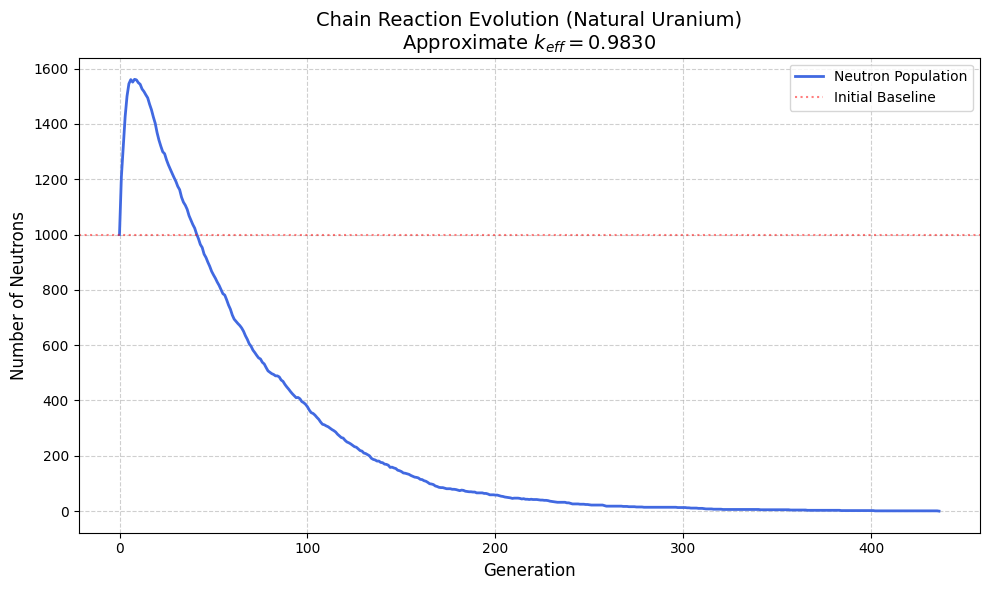

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Run the simulation and capture the history list
gen_final, n_final, neutron_history = simulation() 

# k_eff is the ratio of neutrons between generations (N_i / N_i-1).
# We take an average over the simulation to see the general trend.
if len(neutron_history) > 1:
    # Calculate ratios avoiding division by zero
    ratios = [neutron_history[i]/neutron_history[i-1] for i in range(1, len(neutron_history)) if neutron_history[i-1] > 0]
    avg_k_eff = np.mean(ratios) if ratios else 0.0
else:
    avg_k_eff = 0.0

# 2. Plot results
plt.figure(figsize=(10, 6))

# Main data plot
plt.plot(neutron_history, color='royalblue', linewidth=2, label='Neutron Population')

# Visual baseline (Initial number of neutrons)
plt.axhline(y=neutron_history[0], color='red', linestyle=':', alpha=0.5, label='Initial Baseline')

# Titles and Labels
plt.title(f'Chain Reaction Evolution (Natural Uranium)\nApproximate $k_{{eff}} = {avg_k_eff:.4f}$', fontsize=14)
plt.xlabel('Generation', fontsize=12)
plt.ylabel('Number of Neutrons', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Optional: If it grows or decays exponentially, Log Scale is better for visualization.
# Uncomment the line below to enable logarithmic scale on Y-axis.
# plt.yscale('log') 

plt.tight_layout()
plt.show()